In [1]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
%matplotlib inline

Running on the GPU


In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
                        
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.LayerNorm(32),
            
            nn.Linear(32, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Params state and actions are torch tensors
        """
        
        return self.layers(x)


In [3]:
prefix = '../datasets/0/'
states = np.load(prefix + 'states_array.npy')
actions = np.load(prefix + 'actions_array.npy')
rewards = np.load(prefix + 'rewards_array.npy')
next_states = np.load(prefix + 'next_states_array.npy')
dones = np.load(prefix + 'dones_array.npy')

In [4]:
X = np.concatenate((states, next_states), -1)
# X = states - next_states
Y = actions

In [5]:
permutation = np.random.permutation(X.shape[0])
X = X[permutation]
X_test = torch.from_numpy(X[:100000]).float().to(device)
X_train = torch.from_numpy(X[100000:]).float().to(device)
Y = Y[permutation]
Y_test = torch.from_numpy(Y[:100000]).float().to(device)
Y_train = torch.from_numpy(Y[100000:]).float().to(device)

In [10]:
lr = 1e-2
batch_size = 4096
numBatches = int(np.ceil(X_train.shape[0] / batch_size))

In [11]:
model = MLP(X_train.shape[1], Y_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
lmbda = lambda epoch: 0.9
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)
criterion  = nn.SmoothL1Loss(reduction='none')

In [12]:
trainLosses = []
testLosses = []
learningRates = []
for epoch in range(300):
    
    y_hat = model.forward(X_test)
    loss = criterion(Y_test, y_hat)
    
    testLoss = loss.mean(dim=0).cpu().detach()

    t0 = time.time()
    permutation = np.random.permutation(X_train.shape[0])
    X_train = X_train[permutation]
    Y_train = Y_train[permutation]
    
    epochLoss = torch.zeros(Y_train.shape[1])
    for batch in range(numBatches):
        x = X_train[batch * batch_size:(batch+1)*batch_size]
        y = Y_train[batch * batch_size:(batch+1)*batch_size]
        
        y_hat = model.forward(x)
        
        loss = criterion(y, y_hat)
        
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        epochLoss += loss.mean(dim=0).cpu().detach()
    
    epochLoss /= numBatches
    
    delta_t = time.time() - t0
    
    if epoch % 50 == 49:
        lr_scheduler.step()
        
    testLosses.append(testLoss)
    learningRates.append(lr_scheduler.get_last_lr())
    trainLosses.append(epochLoss)
    
    print('Epoch {} in time {}s \nTraining Loss {} \nTesting  Loss {}\n'.format(
        epoch+1, round(delta_t, 2), np.round(epochLoss, 3), np.round(testLoss, 3)))

Epoch 1 in time 0.71s 
Training Loss tensor([0.0790, 0.0210, 0.0330, 0.0680, 0.0580, 0.0410]) 
Testing  Loss tensor([0.4450, 0.5190, 0.2680, 0.8890, 0.3850, 0.6980])

Epoch 2 in time 0.76s 
Training Loss tensor([0.0200, 0.0040, 0.0050, 0.0260, 0.0170, 0.0080]) 
Testing  Loss tensor([0.0260, 0.0050, 0.0060, 0.0320, 0.0220, 0.0090])

Epoch 3 in time 0.77s 
Training Loss tensor([0.0140, 0.0030, 0.0050, 0.0190, 0.0130, 0.0070]) 
Testing  Loss tensor([0.0160, 0.0030, 0.0050, 0.0220, 0.0150, 0.0070])

Epoch 4 in time 0.74s 
Training Loss tensor([0.0110, 0.0030, 0.0040, 0.0140, 0.0110, 0.0060]) 
Testing  Loss tensor([0.0130, 0.0030, 0.0040, 0.0160, 0.0120, 0.0070])

Epoch 5 in time 0.82s 
Training Loss tensor([0.0100, 0.0030, 0.0040, 0.0120, 0.0110, 0.0060]) 
Testing  Loss tensor([0.0110, 0.0030, 0.0040, 0.0130, 0.0110, 0.0060])

Epoch 6 in time 0.73s 
Training Loss tensor([0.0090, 0.0030, 0.0040, 0.0110, 0.0100, 0.0060]) 
Testing  Loss tensor([0.0090, 0.0030, 0.0040, 0.0120, 0.0100, 0.0060])

Epoch 50 in time 0.79s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 51 in time 0.81s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 52 in time 0.81s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 53 in time 0.79s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 54 in time 0.79s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 55 in time 0.81s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0060, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.

Epoch 99 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 100 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 101 in time 0.79s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0050, 0.0040])

Epoch 102 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 103 in time 0.82s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 104 in time 0.82s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 

Epoch 148 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 149 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 150 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 151 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 152 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 153 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 197 in time 0.85s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 198 in time 0.85s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 199 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 200 in time 0.82s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 201 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 202 in time 0.86s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 246 in time 0.79s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 247 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 248 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 249 in time 0.81s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 250 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 251 in time 0.87s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 295 in time 0.79s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 296 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 297 in time 0.77s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 298 in time 0.78s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 299 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 300 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050

Epoch 344 in time 0.82s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 345 in time 0.78s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 346 in time 0.79s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 347 in time 0.8s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 348 in time 0.78s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 349 in time 0.81s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 393 in time 0.79s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 394 in time 0.79s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 395 in time 0.8s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 396 in time 0.8s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 397 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 398 in time 0.84s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050

Epoch 442 in time 0.9s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 443 in time 0.88s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 444 in time 0.93s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 445 in time 0.88s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 446 in time 0.84s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 447 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 491 in time 0.78s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 492 in time 0.71s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030])

Epoch 493 in time 0.81s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 494 in time 0.81s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 495 in time 0.77s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 496 in time 0.72s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 540 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 541 in time 0.69s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 542 in time 0.8s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 543 in time 0.71s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 544 in time 0.71s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 545 in time 0.69s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0040, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 589 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 590 in time 0.8s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 591 in time 0.79s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 592 in time 0.69s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 593 in time 0.79s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 594 in time 0.68s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 638 in time 0.73s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 639 in time 0.74s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 640 in time 0.74s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 641 in time 0.74s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 642 in time 0.67s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 643 in time 0.73s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 687 in time 0.68s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 688 in time 0.78s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 689 in time 0.77s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 690 in time 0.66s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 691 in time 0.68s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 692 in time 0.73s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 736 in time 0.73s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 737 in time 0.73s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 738 in time 0.76s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 739 in time 0.7s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 740 in time 0.75s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 741 in time 0.72s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 785 in time 0.78s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 786 in time 0.81s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 787 in time 0.78s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 788 in time 0.71s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 789 in time 0.79s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 790 in time 0.84s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 834 in time 0.74s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 835 in time 0.69s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 836 in time 0.78s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 837 in time 0.69s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 838 in time 0.77s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 839 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 883 in time 0.75s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 884 in time 0.67s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 885 in time 0.77s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 886 in time 0.67s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 887 in time 0.75s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 888 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 932 in time 0.9s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 933 in time 0.88s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 934 in time 0.82s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 935 in time 0.91s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 936 in time 0.86s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 937 in time 0.92s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.005

Epoch 981 in time 0.9s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 982 in time 0.9s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 983 in time 0.92s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 984 in time 0.88s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 985 in time 0.85s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 986 in time 0.85s 
Training Loss tensor([0.0030, 0.0020, 0.0030, 0.0030, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050

Epoch 1 in time 0.82s 
Training Loss tensor([0.0850, 0.0260, 0.0220, 0.0700, 0.0580, 0.0330]) 
Testing  Loss tensor([0.4920, 0.5090, 0.2920, 0.7000, 0.3860, 0.3870])

Epoch 2 in time 0.84s 
Training Loss tensor([0.0210, 0.0040, 0.0050, 0.0290, 0.0170, 0.0070]) 
Testing  Loss tensor([0.0300, 0.0050, 0.0060, 0.0360, 0.0200, 0.0080])

Epoch 3 in time 0.87s 
Training Loss tensor([0.0140, 0.0030, 0.0050, 0.0200, 0.0130, 0.0060]) 
Testing  Loss tensor([0.0160, 0.0040, 0.0050, 0.0240, 0.0140, 0.0060])

Epoch 4 in time 1.05s 
Training Loss tensor([0.0110, 0.0030, 0.0050, 0.0150, 0.0110, 0.0060]) 
Testing  Loss tensor([0.0120, 0.0030, 0.0050, 0.0170, 0.0120, 0.0060])

Epoch 5 in time 0.86s 
Training Loss tensor([0.0100, 0.0030, 0.0040, 0.0120, 0.0100, 0.0060]) 
Testing  Loss tensor([0.0110, 0.0030, 0.0040, 0.0140, 0.0110, 0.0060])

Epoch 6 in time 0.88s 
Training Loss tensor([0.0090, 0.0030, 0.0040, 0.0110, 0.0100, 0.0060]) 
Testing  Loss tensor([0.0100, 0.0030, 0.0040, 0.0120, 0.0100, 0.0060])

Epoch 50 in time 0.83s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0050, 0.0040])

Epoch 51 in time 0.86s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0050, 0.0040])

Epoch 52 in time 0.89s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 53 in time 1.04s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0050, 0.0040])

Epoch 54 in time 1.0s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0060, 0.0040])

Epoch 55 in time 0.99s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0

Epoch 99 in time 0.79s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 100 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 101 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 102 in time 0.87s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 103 in time 0.82s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 104 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0050, 0.005

Epoch 148 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 149 in time 0.86s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 150 in time 0.88s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 151 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 152 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 153 in time 0.81s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.00

Epoch 197 in time 0.88s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])

Epoch 198 in time 0.84s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 199 in time 0.88s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0030])

Epoch 200 in time 0.83s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0040, 0.0050, 0.0030]) 
Testing  Loss tensor([0.0040, 0.0020, 0.0030, 0.0050, 0.0050, 0.0040])



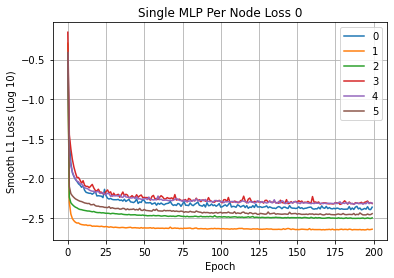

Epoch 1 in time 0.84s 
Training Loss tensor([0.0350, 0.0300, 0.0420, 0.0240]) 
Testing  Loss tensor([0.3560, 0.4120, 0.4650, 0.2670])

Epoch 2 in time 0.9s 
Training Loss tensor([0.0080, 0.0090, 0.0100, 0.0090]) 
Testing  Loss tensor([0.0100, 0.0100, 0.0120, 0.0100])

Epoch 3 in time 0.84s 
Training Loss tensor([0.0070, 0.0080, 0.0080, 0.0080]) 
Testing  Loss tensor([0.0070, 0.0080, 0.0090, 0.0080])

Epoch 4 in time 0.87s 
Training Loss tensor([0.0060, 0.0070, 0.0070, 0.0070]) 
Testing  Loss tensor([0.0060, 0.0070, 0.0070, 0.0070])

Epoch 5 in time 0.84s 
Training Loss tensor([0.0050, 0.0060, 0.0060, 0.0060]) 
Testing  Loss tensor([0.0060, 0.0070, 0.0070, 0.0070])

Epoch 6 in time 0.81s 
Training Loss tensor([0.0050, 0.0060, 0.0060, 0.0060]) 
Testing  Loss tensor([0.0050, 0.0060, 0.0060, 0.0060])

Epoch 7 in time 0.82s 
Training Loss tensor([0.0050, 0.0060, 0.0050, 0.0060]) 
Testing  Loss tensor([0.0050, 0.0060, 0.0060, 0.0060])

Epoch 8 in time 0.94s 
Training Loss tensor([0.0050, 0.0

Epoch 62 in time 0.79s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 63 in time 0.83s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 64 in time 0.86s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 65 in time 0.84s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 66 in time 0.89s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0040, 0.0040])

Epoch 67 in time 0.83s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 68 in time 0.85s 
Training Loss tensor([0.0030, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0040])

Epoch 69 in time 0.87s 
Training Loss tensor([0.

Epoch 123 in time 0.91s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 124 in time 1.02s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 125 in time 0.94s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 126 in time 1.09s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 127 in time 1.0s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0040, 0.0030, 0.0030])

Epoch 128 in time 0.94s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0040])

Epoch 129 in time 0.89s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0040])

Epoch 130 in time 0.87s 
Training Loss ten

Epoch 183 in time 0.9s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 184 in time 0.82s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 185 in time 0.85s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 186 in time 0.97s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 187 in time 0.92s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 188 in time 1.08s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 189 in time 0.94s 
Training Loss tensor([0.0030, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0030, 0.0030])

Epoch 190 in time 0.86s 
Training Loss ten

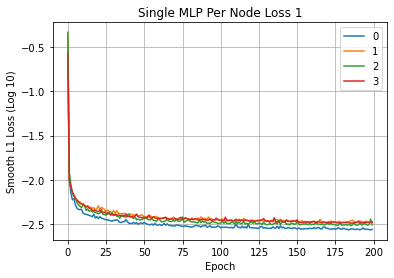

Epoch 1 in time 0.78s 
Training Loss tensor([0.0780, 0.0370, 0.0120, 0.0660, 0.0490]) 
Testing  Loss tensor([0.4250, 0.6030, 0.4210, 0.4570, 0.5590])

Epoch 2 in time 0.78s 
Training Loss tensor([0.0270, 0.0090, 0.0030, 0.0210, 0.0140]) 
Testing  Loss tensor([0.0330, 0.0110, 0.0030, 0.0250, 0.0180])

Epoch 3 in time 0.79s 
Training Loss tensor([0.0190, 0.0070, 0.0020, 0.0160, 0.0110]) 
Testing  Loss tensor([0.0220, 0.0080, 0.0020, 0.0180, 0.0110])

Epoch 4 in time 0.87s 
Training Loss tensor([0.0160, 0.0060, 0.0020, 0.0140, 0.0090]) 
Testing  Loss tensor([0.0180, 0.0070, 0.0020, 0.0150, 0.0090])

Epoch 5 in time 0.81s 
Training Loss tensor([0.0140, 0.0060, 0.0020, 0.0120, 0.0080]) 
Testing  Loss tensor([0.0150, 0.0060, 0.0020, 0.0130, 0.0090])

Epoch 6 in time 0.8s 
Training Loss tensor([0.0130, 0.0060, 0.0020, 0.0110, 0.0080]) 
Testing  Loss tensor([0.0140, 0.0060, 0.0020, 0.0120, 0.0080])

Epoch 7 in time 0.88s 
Training Loss tensor([0.0130, 0.0050, 0.0020, 0.0110, 0.0070]) 
Testing 

Epoch 55 in time 0.86s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0080, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 56 in time 0.87s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0060])

Epoch 57 in time 0.89s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0080, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 58 in time 0.87s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0080, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 59 in time 0.83s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0080, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 60 in time 0.79s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 61 in time 0.81s 
Training Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050]) 


Epoch 109 in time 0.9s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 110 in time 0.9s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 111 in time 0.86s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 112 in time 0.88s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 113 in time 0.86s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 114 in time 0.9s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0070, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 115 in time 0.86s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050

Epoch 163 in time 0.79s 
Training Loss tensor([0.0060, 0.0030, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0060, 0.0050])

Epoch 164 in time 0.79s 
Training Loss tensor([0.0050, 0.0030, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 165 in time 0.79s 
Training Loss tensor([0.0060, 0.0030, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 166 in time 0.79s 
Training Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 167 in time 0.79s 
Training Loss tensor([0.0050, 0.0040, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 168 in time 0.81s 
Training Loss tensor([0.0050, 0.0030, 0.0020, 0.0050, 0.0050]) 
Testing  Loss tensor([0.0060, 0.0040, 0.0020, 0.0050, 0.0050])

Epoch 169 in time 0.78s 
Training Loss tensor([0.0050, 0.0040, 0.0020, 0.0050, 0.0

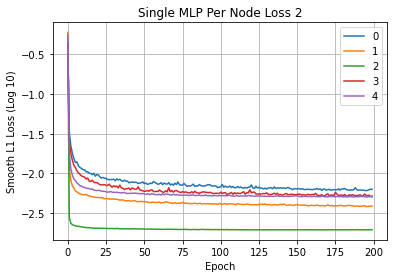

Epoch 1 in time 0.86s 
Training Loss tensor([0.0150, 0.0140, 0.0530, 0.0500, 0.0440]) 
Testing  Loss tensor([0.4270, 0.2240, 0.3670, 0.3200, 0.2360])

Epoch 2 in time 0.81s 
Training Loss tensor([0.0040, 0.0040, 0.0150, 0.0090, 0.0160]) 
Testing  Loss tensor([0.0060, 0.0050, 0.0190, 0.0110, 0.0190])

Epoch 3 in time 0.81s 
Training Loss tensor([0.0040, 0.0030, 0.0110, 0.0080, 0.0120]) 
Testing  Loss tensor([0.0040, 0.0030, 0.0130, 0.0080, 0.0140])

Epoch 4 in time 0.82s 
Training Loss tensor([0.0030, 0.0030, 0.0100, 0.0070, 0.0110]) 
Testing  Loss tensor([0.0040, 0.0030, 0.0110, 0.0070, 0.0110])

Epoch 5 in time 0.87s 
Training Loss tensor([0.0030, 0.0030, 0.0080, 0.0060, 0.0100]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0090, 0.0070, 0.0100])

Epoch 6 in time 0.82s 
Training Loss tensor([0.0030, 0.0030, 0.0080, 0.0060, 0.0090]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0080, 0.0060, 0.0090])

Epoch 7 in time 0.89s 
Training Loss tensor([0.0030, 0.0030, 0.0070, 0.0060, 0.0080]) 
Testing

Epoch 56 in time 0.83s 
Training Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 57 in time 0.84s 
Training Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 58 in time 0.84s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 59 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 60 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 61 in time 0.84s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 62 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Te

Epoch 110 in time 0.83s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 111 in time 0.84s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 112 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 113 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0030, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 114 in time 0.81s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 115 in time 0.81s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 116 in time 0.81s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0

Epoch 164 in time 0.81s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 165 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 166 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 167 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 168 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 169 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0040, 0.0030, 0.0040])

Epoch 170 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0030, 0.0030, 0.0040

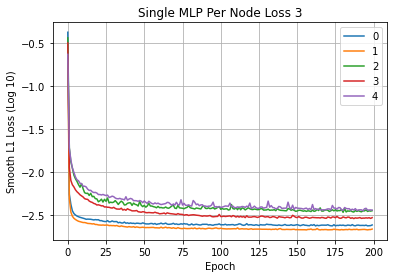

Epoch 1 in time 1.01s 
Training Loss tensor([0.0750, 0.0070, 0.0540, 0.0600, 0.0620, 0.0370, 0.0160]) 
Testing  Loss tensor([0.5590, 0.1020, 0.5630, 0.3860, 0.4480, 0.5090, 0.3690])

Epoch 2 in time 1.01s 
Training Loss tensor([0.0280, 0.0030, 0.0140, 0.0120, 0.0220, 0.0060, 0.0070]) 
Testing  Loss tensor([0.0380, 0.0030, 0.0160, 0.0140, 0.0260, 0.0070, 0.0090])

Epoch 3 in time 1.01s 
Training Loss tensor([0.0190, 0.0020, 0.0110, 0.0110, 0.0170, 0.0040, 0.0040]) 
Testing  Loss tensor([0.0220, 0.0030, 0.0120, 0.0120, 0.0200, 0.0050, 0.0050])

Epoch 4 in time 1.03s 
Training Loss tensor([0.0160, 0.0020, 0.0090, 0.0110, 0.0130, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0170, 0.0020, 0.0100, 0.0110, 0.0150, 0.0040, 0.0030])

Epoch 5 in time 1.02s 
Training Loss tensor([0.0140, 0.0020, 0.0090, 0.0110, 0.0110, 0.0040, 0.0030]) 
Testing  Loss tensor([0.0150, 0.0020, 0.0090, 0.0110, 0.0120, 0.0040, 0.0030])

Epoch 6 in time 1.1s 
Training Loss tensor([0.0130, 0.0020, 0.0080, 0.0100, 0.0100, 0

Epoch 46 in time 0.99s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0020, 0.0050, 0.0070, 0.0050, 0.0030, 0.0020])

Epoch 47 in time 0.96s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0070, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020])

Epoch 48 in time 0.98s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0040, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020])

Epoch 49 in time 0.97s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020])

Epoch 50 in time 0.97s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0040, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.0050, 0.0030, 0.0020])

Epoch 51 in time 1.01s 
Training Loss tensor([0.0060, 0.0020, 0.0040, 0.0070, 0.

Epoch 91 in time 0.99s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 92 in time 0.96s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 93 in time 0.96s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 94 in time 0.97s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 95 in time 0.99s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 96 in time 0.94s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.

Epoch 136 in time 0.96s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 137 in time 0.95s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 138 in time 0.97s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 139 in time 0.96s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 140 in time 0.94s 
Training Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0040, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 141 in time 0.95s 
Training Loss tensor([0.0050, 0.0020, 0.0040, 0.00

Epoch 181 in time 0.97s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0030, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 182 in time 0.95s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0030, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 183 in time 0.96s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0030, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 184 in time 1.01s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0030, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0030, 0.0060, 0.0040, 0.0020, 0.0020])

Epoch 185 in time 0.98s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.0060, 0.0030, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0020, 0.0040, 0.0060, 0.0030, 0.0020, 0.0020])

Epoch 186 in time 0.98s 
Training Loss tensor([0.0040, 0.0020, 0.0030, 0.00

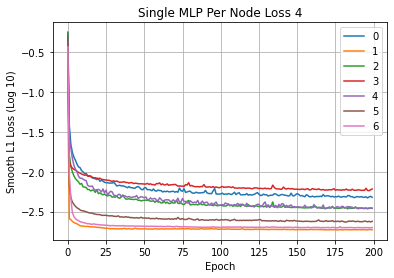

Epoch 1 in time 0.96s 
Training Loss tensor([0.0120, 0.0750, 0.0170, 0.0600, 0.1020, 0.0620, 0.0300]) 
Testing  Loss tensor([0.3130, 0.5170, 0.2410, 0.5110, 0.4860, 0.4280, 0.5290])

Epoch 2 in time 0.97s 
Training Loss tensor([0.0020, 0.0240, 0.0040, 0.0230, 0.0300, 0.0180, 0.0040]) 
Testing  Loss tensor([0.0020, 0.0310, 0.0060, 0.0310, 0.0390, 0.0220, 0.0060])

Epoch 3 in time 1.0s 
Training Loss tensor([0.0020, 0.0180, 0.0030, 0.0160, 0.0220, 0.0140, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0200, 0.0030, 0.0180, 0.0250, 0.0150, 0.0040])

Epoch 4 in time 0.96s 
Training Loss tensor([0.0020, 0.0160, 0.0020, 0.0130, 0.0190, 0.0120, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0160, 0.0030, 0.0150, 0.0200, 0.0130, 0.0030])

Epoch 5 in time 0.97s 
Training Loss tensor([0.0020, 0.0140, 0.0020, 0.0120, 0.0170, 0.0110, 0.0030]) 
Testing  Loss tensor([0.0020, 0.0150, 0.0020, 0.0130, 0.0180, 0.0110, 0.0030])

Epoch 6 in time 0.98s 
Training Loss tensor([0.0020, 0.0130, 0.0020, 0.0110, 0.0160, 0

Epoch 46 in time 0.98s 
Training Loss tensor([0.0020, 0.0090, 0.0020, 0.0060, 0.0090, 0.0070, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0090, 0.0020, 0.0070, 0.0100, 0.0070, 0.0020])

Epoch 47 in time 1.03s 
Training Loss tensor([0.0020, 0.0090, 0.0020, 0.0060, 0.0090, 0.0070, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0090, 0.0020, 0.0070, 0.0090, 0.0070, 0.0020])

Epoch 48 in time 1.0s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0090, 0.0070, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0090, 0.0020, 0.0070, 0.0090, 0.0070, 0.0020])

Epoch 49 in time 0.98s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0090, 0.0070, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0090, 0.0020, 0.0070, 0.0090, 0.0070, 0.0020])

Epoch 50 in time 0.98s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0090, 0.0070, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0090, 0.0020, 0.0070, 0.0100, 0.0070, 0.0020])

Epoch 51 in time 0.98s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0

Epoch 91 in time 1.0s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0090, 0.0060, 0.0020])

Epoch 92 in time 1.01s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0090, 0.0060, 0.0020])

Epoch 93 in time 1.0s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0090, 0.0060, 0.0020])

Epoch 94 in time 1.01s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0090, 0.0060, 0.0020])

Epoch 95 in time 1.02s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0090, 0.0070, 0.0020])

Epoch 96 in time 1.02s 
Training Loss tensor([0.0020, 0.0080, 0.0020, 0.0050, 0.00

Epoch 136 in time 0.95s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0080, 0.0060, 0.0020])

Epoch 137 in time 0.98s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0090, 0.0060, 0.0020])

Epoch 138 in time 0.97s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0070, 0.0090, 0.0060, 0.0020])

Epoch 139 in time 0.96s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 140 in time 0.98s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0080, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 141 in time 0.98s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.00

Epoch 181 in time 0.98s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0070, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0070, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 182 in time 1.01s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0070, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0070, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 183 in time 0.9s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0070, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0070, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 184 in time 0.93s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0070, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0070, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 185 in time 0.93s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.0050, 0.0070, 0.0060, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0080, 0.0020, 0.0060, 0.0080, 0.0060, 0.0020])

Epoch 186 in time 0.82s 
Training Loss tensor([0.0020, 0.0070, 0.0020, 0.005

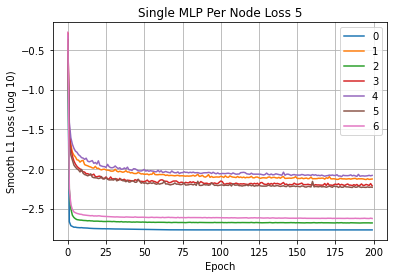

Epoch 1 in time 0.82s 
Training Loss tensor([0.0150, 0.0240, 0.0220, 0.0140, 0.0150, 0.0150, 0.0380, 0.0110]) 
Testing  Loss tensor([0.3130, 0.2590, 0.7990, 0.1410, 0.6470, 0.4770, 0.2590, 0.1230])

Epoch 2 in time 0.8s 
Training Loss tensor([0.0060, 0.0080, 0.0040, 0.0040, 0.0040, 0.0020, 0.0120, 0.0020]) 
Testing  Loss tensor([0.0080, 0.0110, 0.0040, 0.0050, 0.0040, 0.0020, 0.0150, 0.0020])

Epoch 3 in time 0.92s 
Training Loss tensor([0.0050, 0.0060, 0.0030, 0.0030, 0.0040, 0.0020, 0.0100, 0.0020]) 
Testing  Loss tensor([0.0060, 0.0060, 0.0040, 0.0040, 0.0040, 0.0020, 0.0110, 0.0020])

Epoch 4 in time 0.82s 
Training Loss tensor([0.0040, 0.0050, 0.0030, 0.0030, 0.0030, 0.0020, 0.0080, 0.0020]) 
Testing  Loss tensor([0.0050, 0.0050, 0.0030, 0.0030, 0.0040, 0.0020, 0.0090, 0.0020])

Epoch 5 in time 0.88s 
Training Loss tensor([0.0040, 0.0040, 0.0030, 0.0030, 0.0030, 0.0020, 0.0080, 0.0020]) 
Testing  Loss tensor([0.0040, 0.0040, 0.0030, 0.0030, 0.0030, 0.0020, 0.0080, 0.0020])

Epoch 

Epoch 43 in time 0.84s 
Training Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 44 in time 0.84s 
Training Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 45 in time 0.93s 
Training Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 46 in time 0.87s 
Training Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 47 in time 0.9s 
Training Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0030, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

E

Epoch 84 in time 0.81s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 85 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 86 in time 0.79s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 87 in time 0.86s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 88 in time 0.86s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

E

Epoch 125 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020])

Epoch 126 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020])

Epoch 127 in time 0.82s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0020])

Epoch 128 in time 0.85s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0030, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020])

Epoch 129 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020]

Epoch 166 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020])

Epoch 167 in time 0.88s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020])

Epoch 168 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020])

Epoch 169 in time 0.8s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020])

Epoch 170 in time 0.84s 
Training Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020]) 
Testing  Loss tensor([0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0010, 0.0020, 0.0020])

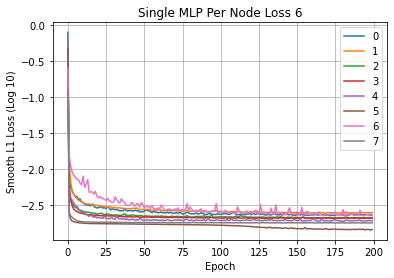

In [9]:
for morphIdx in range(7):
    
    prefix = '../datasets/{}/'.format(morphIdx)
    states = np.load(prefix + 'states_array.npy')
    actions = np.load(prefix + 'actions_array.npy')
    rewards = np.load(prefix + 'rewards_array.npy')
    next_states = np.load(prefix + 'next_states_array.npy')
    dones = np.load(prefix + 'dones_array.npy')
    
    X = np.concatenate((states, next_states), -1)
    Y = actions
    
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test = torch.from_numpy(X[:100000]).float().to(device)
    X_train = torch.from_numpy(X[100000:]).float()
    Y = Y[permutation]
    Y_test = torch.from_numpy(Y[:100000]).float().to(device)
    Y_train = torch.from_numpy(Y[100000:]).float()
    
    lr = 1e-3
    batch_size = 4096
    numBatches = int(np.ceil(X_train.shape[0] / batch_size))
    
    model = MLP(X_train.shape[1], Y_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    lmbda = lambda epoch: 0.9
    lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)
    criterion  = nn.SmoothL1Loss(reduction='none')
    
    trainLosses = []
    testLosses = []
    learningRates = []
    
    for epoch in range(200):

        y_hat = model.forward(X_test)
        loss = criterion(Y_test, y_hat)

        testLoss = loss.mean(dim=0).cpu().detach()

        t0 = time.time()
        permutation = np.random.permutation(X_train.shape[0])
        X_train = X_train[permutation]
        Y_train = Y_train[permutation]

        epochLoss = torch.zeros(Y_train.shape[1])
        for batch in range(numBatches):
            x = X_train[batch * batch_size:(batch+1)*batch_size].to(device)
            y = Y_train[batch * batch_size:(batch+1)*batch_size].to(device)

            y_hat = model.forward(x)

            loss = criterion(y, y_hat)

            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()

            epochLoss += loss.mean(dim=0).cpu().detach()

        epochLoss /= numBatches

        delta_t = time.time() - t0

        if epoch % 100 == 49:
            lr_scheduler.step()

        testLosses.append(testLoss)
        learningRates.append(lr_scheduler.get_last_lr())
        trainLosses.append(epochLoss)

        print('Epoch {} in time {}s \nTraining Loss {} \nTesting  Loss {}\n'.format(
            epoch+1, round(delta_t, 2), np.round(epochLoss, 3), np.round(testLoss, 3)))
        
    lossArr = torch.stack(testLosses).T
    fig, ax = plt.subplots(1, sharex=True)
    
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), torch.log10(lossArr[i]))
        
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Epoch')
    plt.grid()
    plt.ylabel('Smooth L1 Loss (Log 10)')
    plt.title('Single MLP Per Node Loss {}'.format(morphIdx))
    plt.savefig('single-mlp-per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()

In [ ]:
torch.save(model, 'inverseDynamics-doublePendlum-MLP.pt')